In [5]:
import numpy as np
import matplotlib 
import matplotlib as mpl
import traceback

import lightkurve 
from lightkurve import KeplerLightCurve, KeplerTargetPixelFile

import halophot
from k2sc.standalone import k2sc_lc
import k2sc

from astropy.table import Table
from astropy.io import fits
import fitsio

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']



Populating the interactive namespace from numpy and matplotlib


In [2]:
!halo ktwo212573842-c06_lpd-targ.fits.gz  --data-dir ../data/ --save-dir . --name Spica -c 6 --thresh 0.5 --minflux -100 --rr [0,17.5] --do-plot --lag 10

Data loaded!
Getting annulus from 0.0 to 17.5
Using 416 pixels
Not splitting
Taking cadences from beginning to end
399 saturated pixels
Throwing out 11 bad cadences
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Sigma clipping
Clipping 3 bad points
Calculated weights!
Time taken: 0.511913 s
Total variation per point (first order): 0.001459 
Saved halo-corrected light curve to ./Spica_halo_lc_tv.fits
Everything saved to ./Spica_all_tv.png


In [6]:
f = fitsio.FITS('./Spica_halo_lc_o1.fits')
hdr = fitsio.read_header('./Spica_halo_lc_o1.fits')


/anaconda3/lib/python3.7/site-packages/halophot-0.7.0.4-py3.7.egg/halophot/halo_tools.py:562: RuntimeWarning: divide by zero encountered in log10


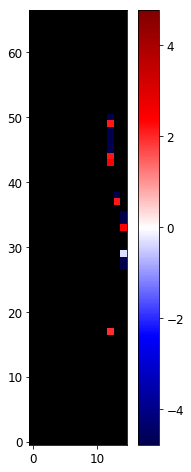

In [7]:
fig = plt.figure(figsize=(12.0,8.0))
ax = plt.axes()
halophot.halo_tools.plot_weightmap(ax,f[0][:,:].T,'Spica')

In [8]:
def match_cadences(halocads,lccads):
    indices =np.array([1 if j in lccads else 0 for j in halocads])
    return np.where(indices==1)[0]



In [9]:
tpf = lightkurve.open('../data/ktwo212573842-c06_lpd-targ.fits.gz')
lc = tpf.to_lightcurve('aperture')
lc.pos_corr1 = tpf.pos_corr1
lc.pos_corr2 = tpf.pos_corr2
lc.primary_header = tpf.hdu[0].header
lc.data_header = tpf.hdu[1].header

inds_lc = match_cadences(lc.cadenceno,f[1]['cadence'][:])
lc = lc[inds_lc]
lc.pos_corr1 = lc.pos_corr1[inds_lc]
lc.pos_corr2 = lc.pos_corr2[inds_lc]


inds_flux = match_cadences(f[1]['cadence'][:],lc.cadenceno)
lc.flux = f[1]['corr_flux'][inds_flux]

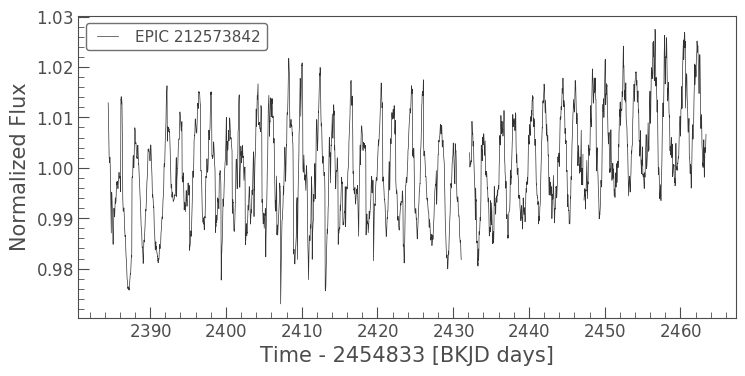

In [10]:
lc.plot()

/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:908: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


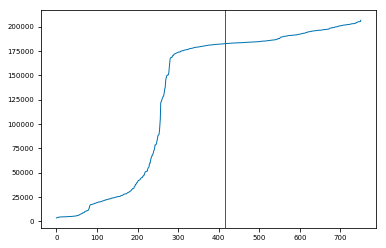

In [55]:
pixels = np.nanmedian(tpf.flux,axis=0).flatten()
pixels.sort()
pixels = pixels[np.isfinite(pixels)]
plt.plot(pixels)
plt.axvline(len(pixels)-335)
plt.axvline(416)

In [56]:
# now the magic happens
lc.__class__ = k2sc_lc
lc.campaign = 6

In [57]:
lc.k2sc()

Using default splits [2390, 2428] for campaign 6
Starting initial outlier detection
  Flagged 49 ( 1.4%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =    2.01 (fap 0.0000e+00 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE
  DE iteration %3i -ln(L) %4.1f 0 -3788.3026076953934
  DE iteration %3i -ln(L) %4.1f 1 -3788.3026076953934
  DE iteration %3i -ln(L) %4.1f 2 -3801.849590872038
  DE iteration %3i -ln(L) %4.1f 3 -3801.849590872038
  DE iteration %3i -ln(L) %4.1f 4 -3825.8577730165907
  DE iteration %3i -ln(L) %4.1f 5 -3825.8577730165907
  DE iteration %3i -ln(L) %4.1f 6 -3833.2962930321473
  DE iteration %3i -ln(L) %4.1f 7 -3833.2962930321473
  DE iteration %3i -ln(L) %4.1f 8 -3833.2962930321473
  DE iteration %3i -ln(L) %4.1f 9 -3843.880628347928
  DE iteration %3i -ln(L) %4.1f 10 -3843.880628347928
  DE iteration %3i -ln(L) %4.1f 11 -3845.318902053055
  DE iteration %3i -ln(L) %4.1

In [58]:
to_save = ['time', 'flux', 'flux_err','centroid_col', 'centroid_row', 'quality', 'cadenceno','pos_corr1', 'pos_corr2','tr_position', 'tr_time','corr_flux']

dummy = fits.getheader('../data/ktwo212573842-c06_lpd-targ.fits.gz')
dummy['NAXIS']=1
dummy['halo'] =(halophot.__version__,'halophot version')
dummy['order']=(1,'halophot TV order')
dummy['sub']=(1,'halophot subsampling')
dummy['starname']=('Spica','Star Identifier')

hdu = fits.PrimaryHDU(f[0][:,:],dummy) # can't save a masked array yet so just using pixelmap
cols = [fits.Column(name=key,format="D",array=lc.__dict__[key]) for key in to_save]
tab = fits.BinTableHDU.from_columns(cols)


hdul = fits.HDUList([hdu, tab])
hdul.writeto('spica_c6_halo_k2sc.fits',overwrite=True)


In [59]:
from halophot.halo_tools import *

def plot_k2sc(lc,image,weightmap,save_file=None,formal_name='test'):
    min_p,max_p=1./24.,20.

    PW,PH = 8.27, 11.69
    
    frequency, power, spower = get_pgram(lc.time,lc.corr_flux-lc.tr_time,min_p=min_p,max_p=max_p)
    
    rc('axes', labelsize=7, titlesize=8)
    rc('font', size=6)
    rc('xtick', labelsize=7)
    rc('ytick', labelsize=7)
    rc('lines', linewidth=1)
    fig = plt.figure(figsize=(PW,PH))
    gs1 = GridSpec(3,2)
    gs1.update(top=0.95, bottom = 2/3.*1.05,hspace=0.0,left=0.09,right=0.96)
    gs2 = GridSpec(1,2)
    gs2.update(top=2/3.*0.97,bottom=1/3.*1.07,hspace=0.35,left=0.09,right=0.96)
    gs3 = GridSpec(2,2)
    gs3.update(top=1/3.*0.96,bottom=0.04,hspace=0.07,left=0.09,right=0.96)

    ax_lctime = subplot(gs1[0,:])
    ax_lcpos = subplot(gs1[1,:],sharex=ax_lctime)
    ax_lcwhite = subplot(gs1[2,:],sharex=ax_lctime)
    ax_fluxmap = subplot(gs2[0,0])
    ax_weightmap = subplot(gs2[0,1])
    ax_periodogram   = subplot(gs3[0,:])
    ax_logpgram    = subplot(gs3[1,:])

    plot_lc(ax_lctime,lc.time,lc.flux-lc.tr_time+np.nanmedian(lc.tr_time),formal_name,trend=lc.tr_position)
    plot_lc(ax_lcpos,lc.time,lc.flux-lc.tr_position+np.nanmedian(lc.tr_position),formal_name,trend=lc.tr_time)
    plot_lc(ax_lcwhite,lc.time,lc.corr_flux-lc.tr_time,formal_name+': Whitened')
    plot_weightmap(ax_weightmap,weightmap,formal_name)
    plot_fluxmap(ax_fluxmap,image,formal_name)
    plot_pgram(ax_periodogram,frequency,power,spower,formal_name)        
    plot_log_pgram(ax_logpgram,frequency,power,spower,formal_name)  

    fig.suptitle(formal_name+' Detrended',y=0.99,fontsize=20)
    ax_periodogram.set_title('Periodograms')
    ax_fluxmap.set_title('Flux Map')
    ax_weightmap.set_title('TV-Min Weight Map')

    if save_file is not None:
        plt.savefig(save_file)
        
def plot_lc(ax1,time,lc,name,trend=None,title=False):
        m = (lc>0.) * (np.isfinite(lc))

        ax1.plot(time[m],lc[m]/np.nanmedian(lc[m]),'.')
        dt = np.nanmedian(time[m][1:]-time[m][:-1])
        ax1.set_xlim(time[m].min()-dt,time[m].max()+dt)
        if trend is not None:
            ax1.plot(time[m],trend[m]/np.nanmedian(trend[m]),'-',color=colours[2])
            plt.legend(labels=['Flux','Trend'])
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Relative Flux')
        if title:
            plt.title(r'%s' % name)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
/anaconda3/lib/python3.7/site-packages/halophot-0.6.6.9-py3.7.egg/halophot/halo_tools.py:659: RuntimeWarning: divide by zero encountered in log10
  im = np.log10(weightmap.T*norm)


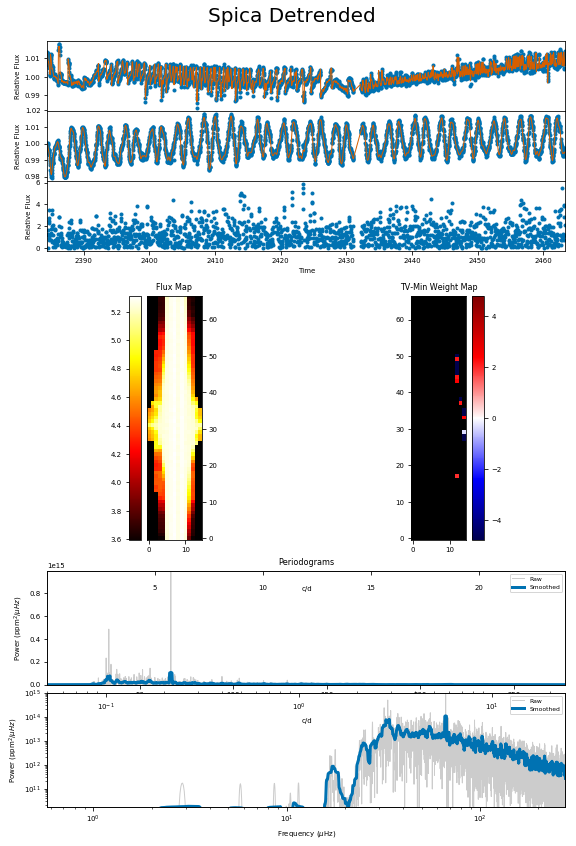

In [60]:
plot_k2sc(lc,np.nanmean(tpf.flux,axis=0),f[0][:,:].T,formal_name='Spica',save_file='spica_plots.png')